Final Project for BMEN4470 - Deep Learning for Biomedical Signal Processing

Project Members: Amy Jang, George Saab, Mark Kirichev

# 5 steps to implement a GAN

  1. Define the GAN architecture basen on the dataset
  2. Train the discriminator to distinguish real vs fake data
  3. Train the generator to fake data that can fool the discriminator
  4. Continue discriminator and generator training for multiple epochs
  5. Save generator model to create new, realistic fake data

In [ ]:
# Imports

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

import sys
import os
import numpy as np
from tqdm import tqdm
import scipy.io as sio
import pandas as pd

print(tf.__version__)

2.7.0


# Connecting to Google Drive and loading the data

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
data_path = '/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset'
print('Available data', os.listdir(data_path))
print('Number of files', len(os.listdir(data_path)))

Available data ['Samples', 'part_12.mat', 'part_10.mat', 'part_11.mat', 'part_1.mat', 'part_3.mat', 'part_2.mat', 'part_4.mat', 'part_5.mat', 'part_7.mat', 'part_6.mat', 'part_8.mat', 'part_9.mat', 'Divided_CSV_Files', '.ipynb_checkpoints', 'generator_model_1K.h5', 'generator_model_5K.h5', 'generator_model_2K.h5', 'generator_model_4K.h5', 'generator_model_10K.h5', 'generator_model_2_9K.h5']
Number of files 21


In [ ]:
mats_list = []
for i in range(1, 13):
  current_mat_str = '/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/part_' + str(i) + '.mat'
  mats_list.append(sio.loadmat(current_mat_str)['p'][0])

data = np.concatenate(mats_list)
total_number_of_samples = len(data)
print(f"Number of samples: {total_number_of_samples}")

Number of samples: 12000


In [ ]:
# Free the memory
del mats_list

In [ ]:
# Split data

ppg = []
abp = []
ecg = []

for sample in data:
  ppg.append(sample[0][:1000])
  abp.append(sample[1][:1000])
  ecg.append(sample[2][:1000])

pd.DataFrame(ppg).to_csv('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/Divided_CSV_Files/ppg.csv', index_label=False)
pd.DataFrame(abp).to_csv('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/Divided_CSV_Files/abp.csv', index_label=False)
pd.DataFrame(ecg).to_csv('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/Divided_CSV_Files/ecg.csv', index_label=False)

In [ ]:
ppg = pd.read_csv('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/Divided_CSV_Files/ppg.csv')
abp = pd.read_csv('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/Divided_CSV_Files/abp.csv')
ecg = pd.read_csv('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/Divided_CSV_Files/ecg.csv')

In [ ]:
data = np.stack((ppg, ecg), axis=-1)
X_train = data[:9600]
X_val = data[9600:10800]
X_test = data[10800:]

y_train = abp[:9600]
y_val = abp[9600:10800]
y_test = abp[10800:]

print(X_train.shape, y_train.shape)

(9600, 1000, 2) (9600, 1000)


In [ ]:
# getting the global max and min values becuase we'll need them
# for a normalization later

min_X_train = np.min(X_train)
max_X_train = np.max(X_train)

print(min_X_train)
print(max_X_train)

-7.49609375
4.5


# GAN Code Implementation

In [ ]:
# Defining global constants

signal_shape = (1000, 2)
d_loss_list = []
g_loss_list = []
epoch_times = []

How LeakyReLu works

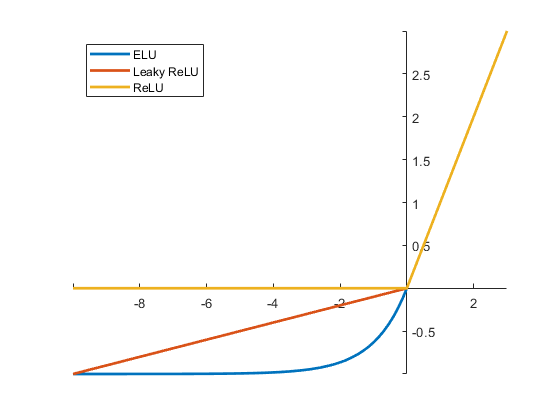

* The alpha parameter in the following implementation represents how large the angle with the x-axis is.

In [ ]:
def build_generator():

    # Defining the constants
    alpha_val = 0.2
    momentum_val = 0.8
    number_of_dense_layers = 3
    initial_dense_layer_neurons = 256
    
    # Initializing the dense layers for the generator

    dense_layers = []
    for i in range(number_of_dense_layers):
      dense_layers.append(initial_dense_layer_neurons << i)

    # 1D array of size 100 (latent vector / noise)
    noise_shape = (100, )


    # Step 1: Define the GAN architecture basen on the dataset      
    model = Sequential()

    # Adding 'number_of_dense_layers' sets of:
    # (dense layer, LeakyReLu, BatchNormalization)
    for i, dense_layer_neurons_number in enumerate(dense_layers):
      model.add(Dense(dense_layer_neurons_number)) if not i == 0 else model.add(Dense(dense_layer_neurons_number, input_shape=noise_shape))
      model.add(LeakyReLU(alpha=alpha_val))
      model.add(BatchNormalization(momentum=momentum_val))
    
    # Adding a final dense layer
    model.add(Dense(np.prod(signal_shape), activation='tanh'))
    model.add(Reshape(signal_shape))

    model.build(input_shape=signal_shape)
    model.summary()

    noise = Input(shape=noise_shape)
    signal = model(noise)    # Generated signal

    return Model(noise, signal)

In [ ]:
def build_discriminator():

    # Defining the constants
    alpha_val = 0.2
    dense_layers = [512, 256]

    model = Sequential()

    model.add(Flatten(input_shape=signal_shape))

    for dense_layer_neurons_number in dense_layers:
      model.add(Dense(dense_layer_neurons_number))
      model.add(LeakyReLU(alpha=alpha_val))
    
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    signal = Input(shape=signal_shape)
    validity = model(signal)

    return Model(signal, validity)

In [ ]:
def normalization(num):
  k = 2 / (max_X_train - min_X_train)
  m = (- min_X_train - max_X_train) / (max_X_train - min_X_train)
  norm = k * num + m
  return norm


for sample in X_train:
  for arr in sample:
    arr[0] = normalization(arr[0])
    arr[1] = normalization(arr[1])

In [ ]:
def train(epochs, batch_size=128):

    half_batch = int(batch_size / 2)

    # Now we start iterating over the epochs and training both our discriminator
    # and generator, one after another. We train the discriminator first, by
    # feeding it real data (the half_batch) then training the generator with 
    # both real and fake data (separately). After that, we compute the loss and
    # continue to iterate until both the generator and discriminator have been trained.
    for epoch in tqdm(range(epochs)):

        # Save the times so we can analyze them after
        initial_time_for_epoch = time.clock()

        #  Train Discriminator

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        signals = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake signals
        gen_signals = generator.predict(noise)

        # Train the discriminator on real and fake signals, separately

        d_loss_real = discriminator.train_on_batch(signals, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_signals, np.zeros((half_batch, 1)))
        
        # calculate the average square error of the real & false predictions
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

        # Now it's time to train our generator. Its idea is to 'fool' the discriminator
        # meaning that we're trying to get the discriminator to mark the fake signals
        # as real and vice-versa

        # Create noise vectors as input for generator.
        noise = np.random.normal(0, 1, (batch_size, 100))

        # The generator wants the discriminator to label the generated samples
        # as valid (true i.e. one)
        # This is where the genrator is trying to trick discriminator into believing
        # the generated image is true (hence value of true (one) for y)
        valid_y = np.array([1] * batch_size)

        # Now get the general loss by training both at the same time
        g_loss = combined.train_on_batch(noise, valid_y)


        # In order to have some type of logging, we print the data
        print (f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")
        
        d_loss_list.append(d_loss[0])
        g_loss_list.append(g_loss)

        if epochs % 1000 == 0:
          number_of_thousands = int(epochs / 1000)
          discriminator_weights_file = f'/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/GAN_Weights/discriminator_{number_of_thousands}K'
          generator_weights_file = f'/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/GAN_Weights/discriminator_{number_of_thousands}K'
          discriminator.save_weights(discriminator_weights_file)
          generator.save_weights(generator_weights_file)
        
        end_time_for_epoch = time.clock()
        epoch_times.append(end_time_for_epoch - initial_time_for_epoch)

In [ ]:
# Adding a timer callback to track the time

class timecallback(Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.clock()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.clock() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()

In [ ]:
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))
signal = generator(z)

discriminator.trainable = False
valid = discriminator(signal)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# timetaken = timecallback()

train(epochs=10000, batch_size=32)
generator.save('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/generator_model_10K.h5')

In [ ]:
from keras.models import load_model

noise_to_predict = np.random.normal(0, 1, (32, 100))
# Load the model if needed
# generator = load_model('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/generator_model_10K.h5')

# Make a prediction
generated_signal = generator.predict(noise_to_predict)
print(generated_signal.shape)

# Plot the time per epoch needed
plt.plot(epoch_times[:])
plt.plot(generated_signal[4, 700:750])

# Plot the loss values for the discriminator and generator
plt.plot(d_loss_list[:])
plt.plot(g_loss_list[:])


# Get the min difference between discriminator and generator loss values
min_loss = 20
min_i = 0
for i in range(500, 2900):
  if min_loss > abs(d_loss_list[i] - g_loss_list[i]):
    min_loss = abs(d_loss_list[i] - g_loss_list[i])
    min_i = i


print(min_loss, min_i)